# This program uses Long Short Term Memory to predict the closing stock price. The prediction is based on the past 60 days stock price.

In [33]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt


In [34]:
# Get the stock quote
crypto_currency = 'BTC'
against_currency = 'USD'
data_source ='yahoo'
period = 60

start = dt.datetime(2012, 1, 1)
end = dt.datetime.now() - dt.timedelta(period + 1)

ticket = f'{crypto_currency}-{against_currency}'

df = web.DataReader(ticket, data_source=data_source, start=start, end=end)
df.shape

(2374, 6)

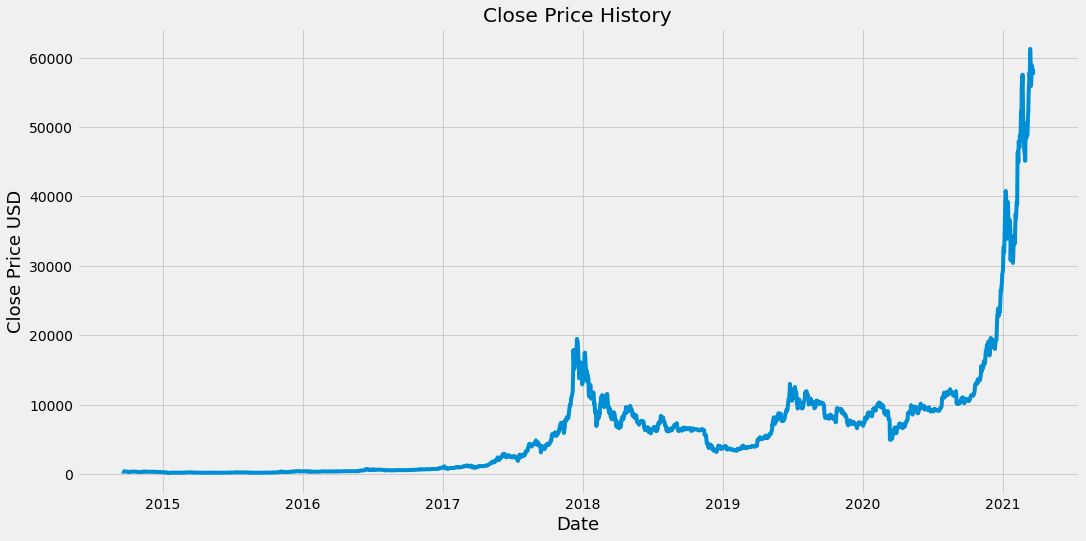

In [35]:
# Closing price history
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [36]:
# Filtering with Close Column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1900

In [37]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00457269],
       [0.00403401],
       [0.00354856],
       ...,
       [0.95256801],
       [0.95202748],
       [0.93908679]])

In [38]:
# Creating Data set
train_data = scaled_data[0:training_data_len, :]
x_train, y_train = [], []

for i in range(period, len(train_data)):
  x_train.append(train_data[i-period:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1840, 60), (1840,))

In [39]:
# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1840, 60, 1)

In [40]:
# Building the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1840/1840 [==============================] - 44s 23ms/step - loss: 4.9036e-04
Epoch 2/10
1840/1840 [==============================] - 41s 22ms/step - loss: 1.1510e-04
Epoch 3/10
1840/1840 [==============================] - 40s 22ms/step - loss: 8.2389e-05
Epoch 4/10
1840/1840 [==============================] - 41s 22ms/step - loss: 9.3851e-05
Epoch 5/10
1840/1840 [==============================] - 41s 22ms/step - loss: 6.5489e-05
Epoch 6/10
1840/1840 [==============================] - 41s 22ms/step - loss: 8.4263e-05
Epoch 7/10
1840/1840 [==============================] - 41s 22ms/step - loss: 5.1436e-05
Epoch 8/10
1840/1840 [==============================] - 41s 22ms/step - loss: 3.9584e-05
Epoch 9/10
1840/1840 [==============================] - 41s 22ms/step - loss: 4.9535e-05
Epoch 10/10
1840/1840 [==============================] - 41s 22ms/step - loss: 4.3093e-05


In [13]:
# Testing Data Set
test_data = scaled_data[training_data_len - period: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(period, len(test_data)):
  x_test.append(test_data[i-period:i, 0])

x_test = np.array(x_test)
x_test.shape

(486, 60)

In [14]:
# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(486, 60, 1)

In [15]:
# Test the model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

predictions.shape

(486, 1)

In [16]:
# RMSE
# rmse = np.sqrt(np.mean((predictions - y_test)**2))
# rmse = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(predictions)), 2)))
rmse = np.sqrt(((predictions - y_test)**2).mean())
rmse

3394.7305796611404

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


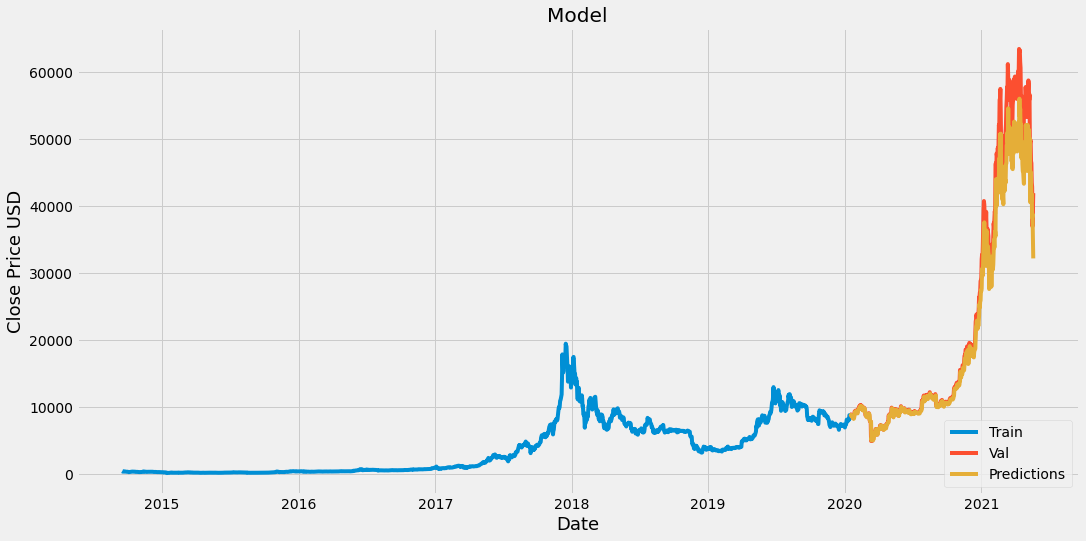

In [18]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
# Valid - Predicted
valid

,Close,Predictions
Date,,
2020-01-17,8929.038086,8661.692383
2020-01-18,8942.808594,8850.259766
2020-01-19,8706.245117,8866.557617
2020-01-20,8657.642578,8633.272461
2020-01-21,8745.894531,8577.382812
...,...,...
2021-05-15,46456.058594,40843.117188
2021-05-16,43537.511719,41824.296875
2021-05-17,42909.402344,38334.066406


In [21]:
# Predicted last know price
end = dt.datetime.now() - dt.timedelta(2)

df_predicted = web.DataReader(ticket, data_source=data_source, start=start, end=end)
new_df = df_predicted.filter(['Close'])
last_60_days = new_df[-period:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price[0][0]), 6)

print(f'Predicted price: ${pred_price}')

Predicted price: $7242.23584


In [28]:
next = dt.datetime.now() - dt.timedelta(1)

df_real = web.DataReader(ticket, data_source=data_source, start=next, end=next)
real_price = df_real['Close'].values

real_price = round(float(real_price[0]), 6)
print(f'Real price: ${real_price}')

Real price: $7276.802734


In [29]:
diff = (real_price - pred_price)
dffp = 100 * diff / real_price
print(f'Difference: ${round(diff,2)} {round(dffp,2)}%')

Difference: $34.57 0.48%


In [42]:
# Predicted last know price
end = dt.datetime.now()

df_predicted = web.DataReader(ticket, data_source=data_source, start=start, end=end)
new_df = df_predicted.filter(['Close'])
last_60_days = new_df[-period:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price[0][0]), 6)

print(f'Predicted price: ${pred_price}')

Predicted price: $42359.917969
